<a href="https://colab.research.google.com/github/m-zaniolo/CEE690-ESAA/blob/main/L01_Lake_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Lab 1
_____________




## _Load data and plot_

We'll use the `loadtxt` function from numpy to read the txt. It can be used for .csv files as well.

The delimiter is a tab `\t`. Other options might be space `\s` or comma `,`.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

inflow = np.loadtxt('data/inflow.txt', delimiter='\t') #m3/s
release = np.loadtxt('data/release1.txt', delimiter='\t') #m3/s


#### First plot: time series of inflow

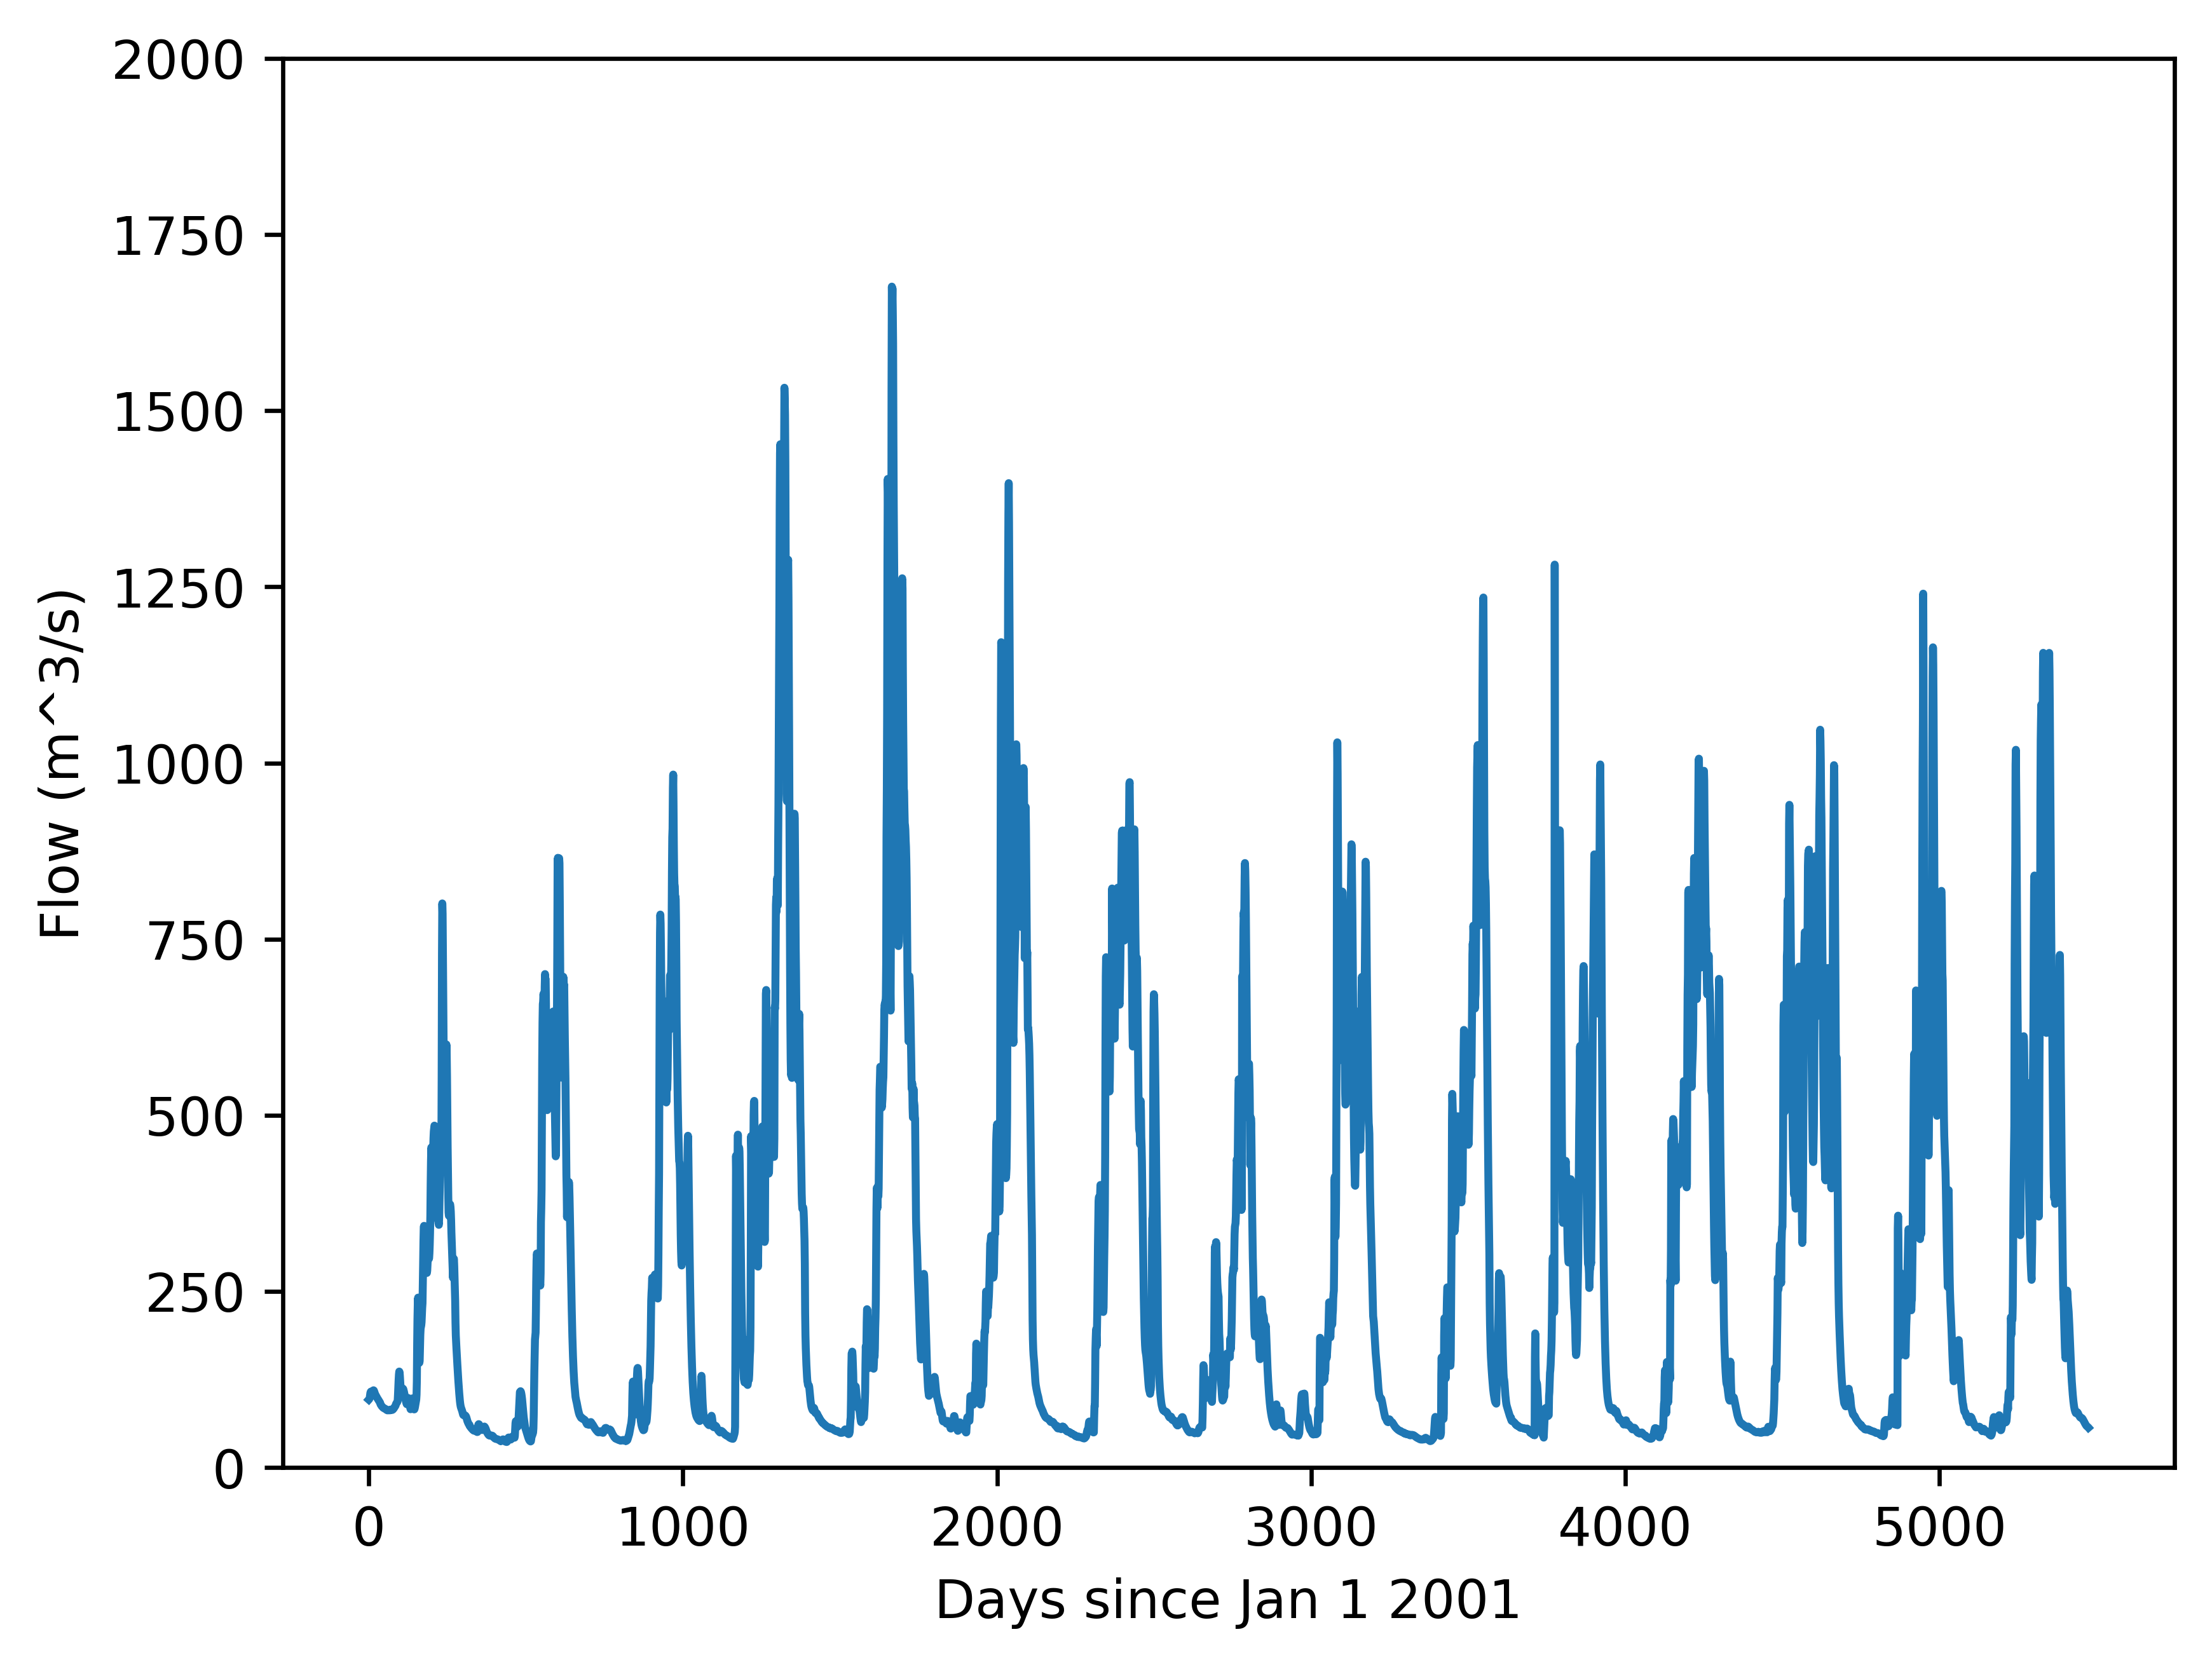

In [ ]:
plt.plot(inflow)
plt.xlabel('Days since Jan 1 2001')
plt.ylabel('Flow (m3/s)')
plt.ylim([0,2000])
plt.show()

#### Second plot: time series of release outflow



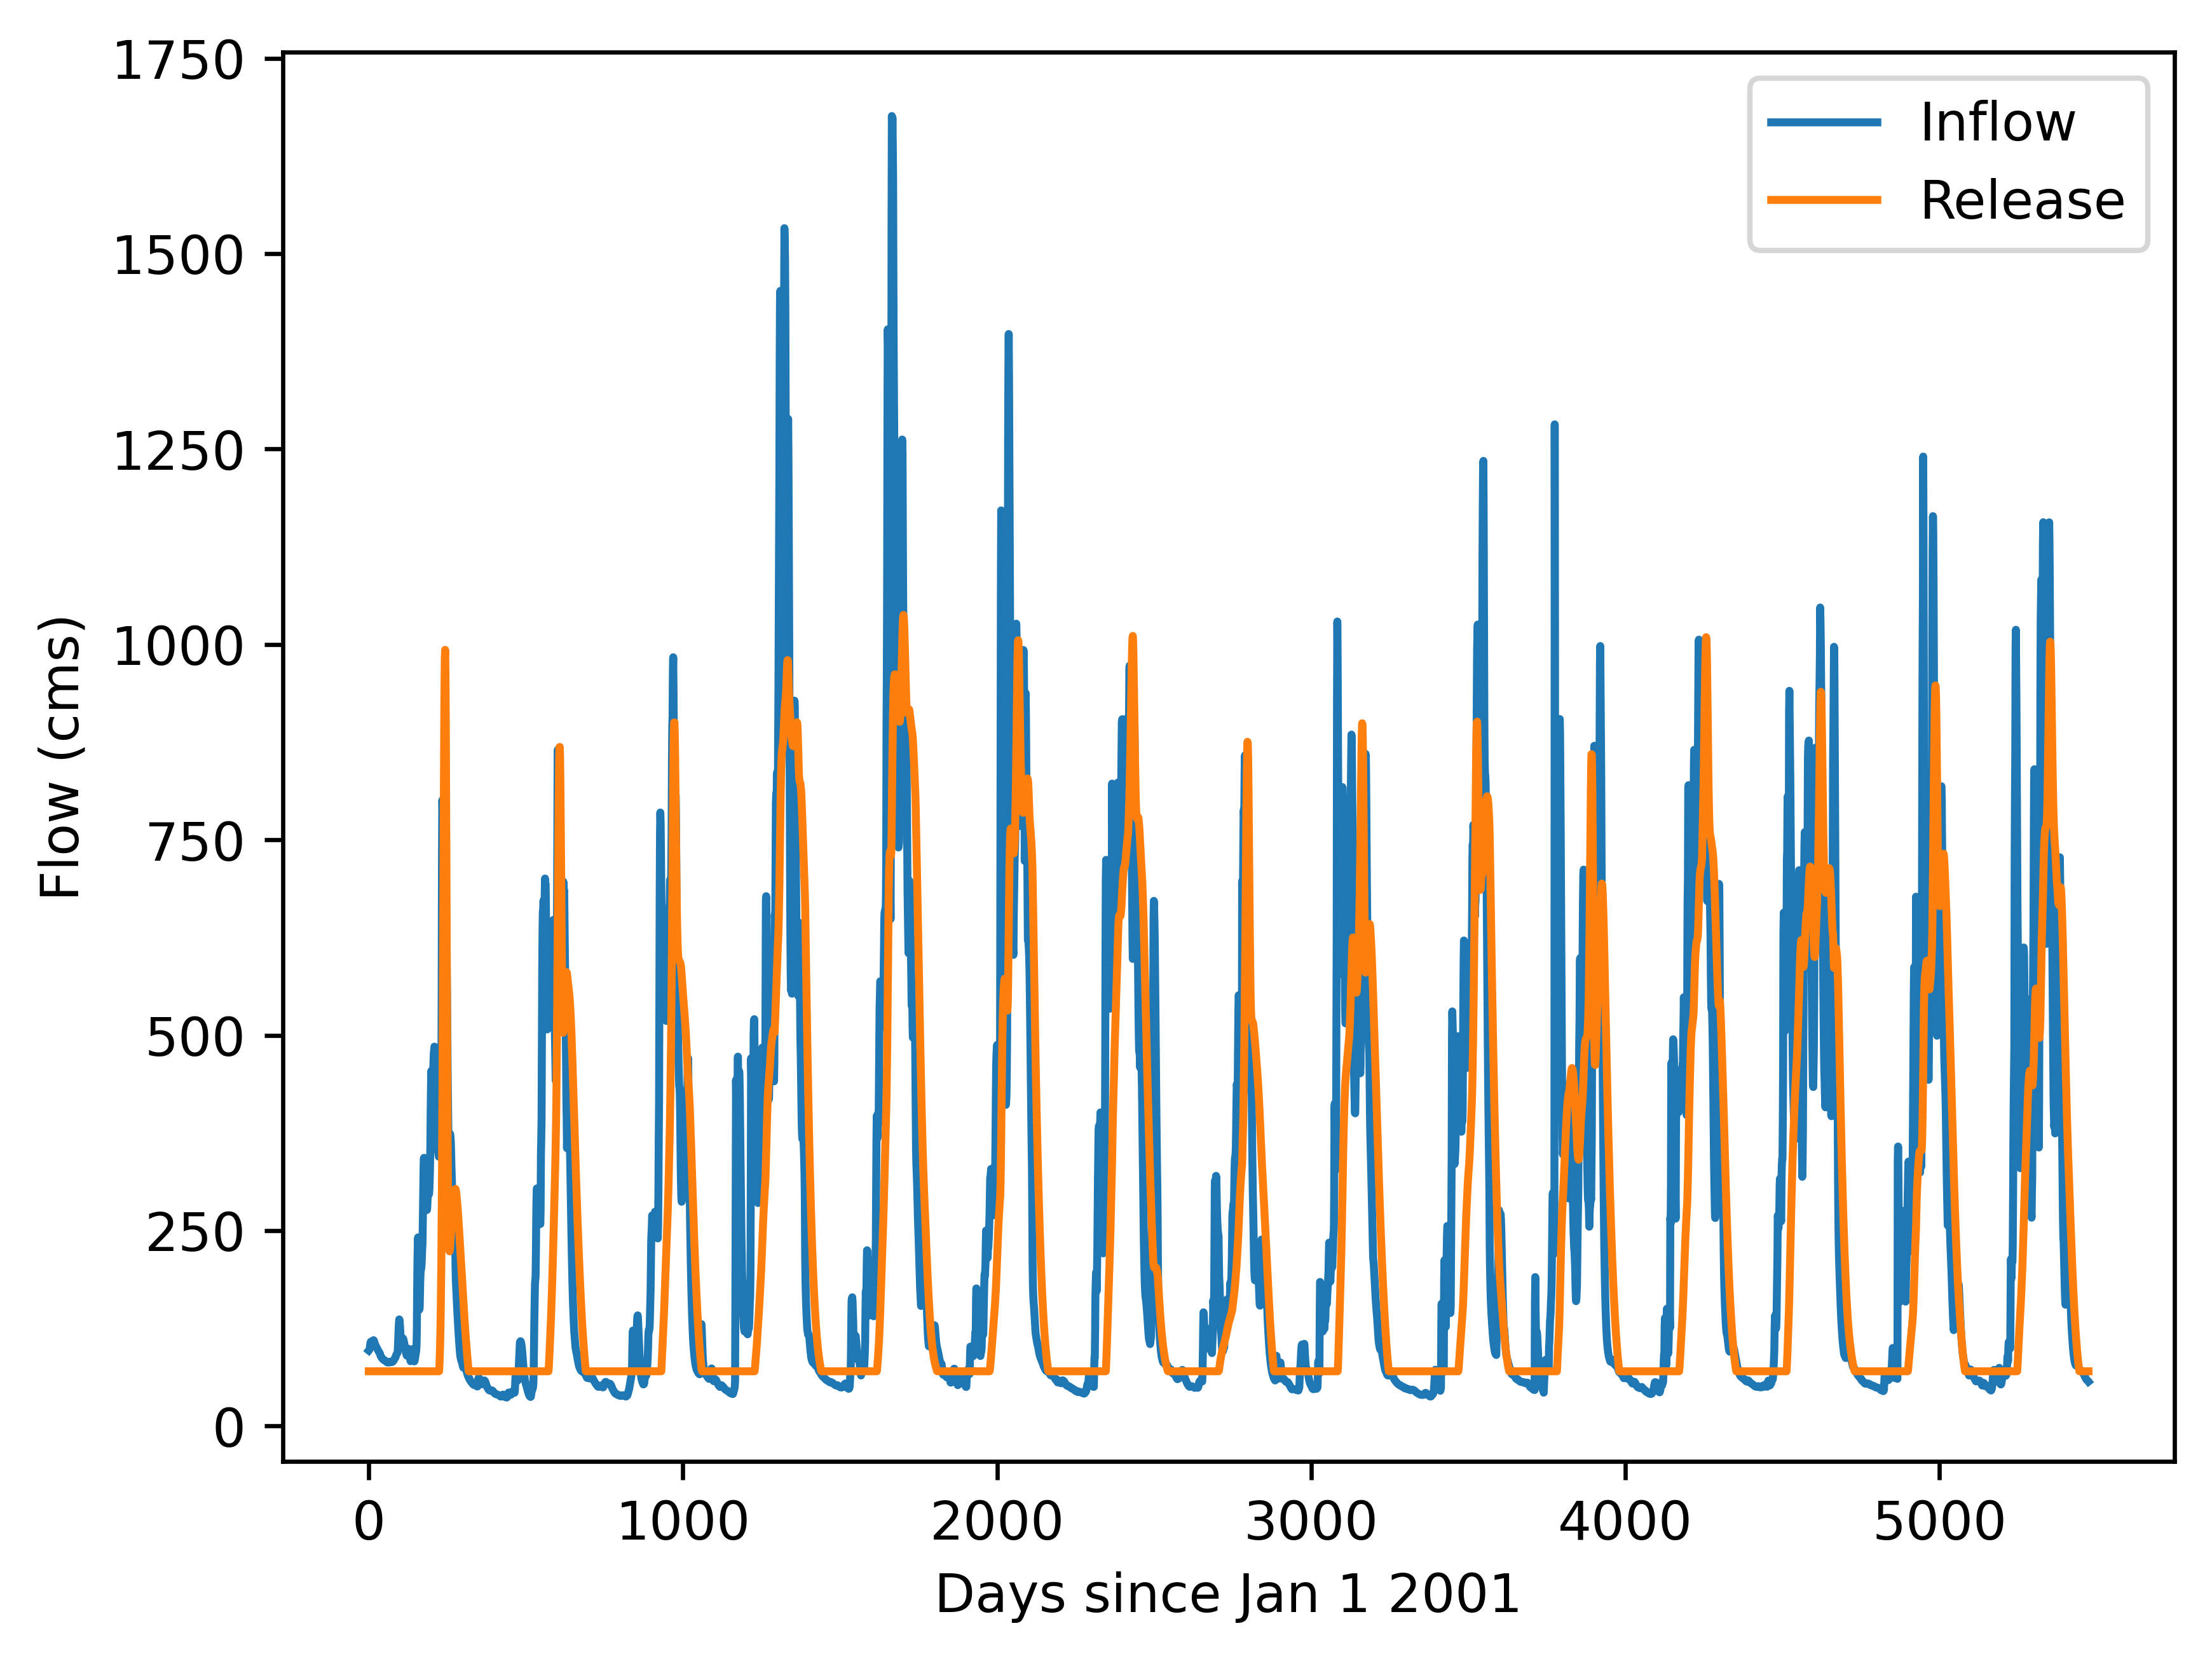

In [ ]:
plt.plot(inflow)
plt.plot(release)
plt.xlabel('Days since Jan 1 2001')
plt.ylabel('Flow (m3/s)')
plt.legend(['Inflow', 'Release'])
plt.show()

# optional - save to file
# plt.savefig('something.png') # or .pdf, .svg, etc.



---



## Simulation model

Mass balance reservoir simulation. Let's define reservoir characteristics

In [ ]:
S = 1.47e10 #m3
H = len(inflow) #length of the simulation horizon
evap = np.loadtxt('data/netevap_Gibe1.txt', delimiter=' ') # load cyclostationary evaporation
sim_step = 60*60*24 #seconds in a day

s = np.zeros(H+1)  # allocate storage vector
s[0] = S*0.7 # for example, let's inizialize storage value at 70% of the max capacity
stor_to_surface = 0.0142  #m2/m3
# stor_to_level = 0.0521*storage^0.3589


Simple reservoir mass balance with time convention:

storage(t+1) = storage(t) + inflow(t+1) - release(t+1) - evap(t)

evaporation is calculated by multiplying net evaporation by the reservoir surface.


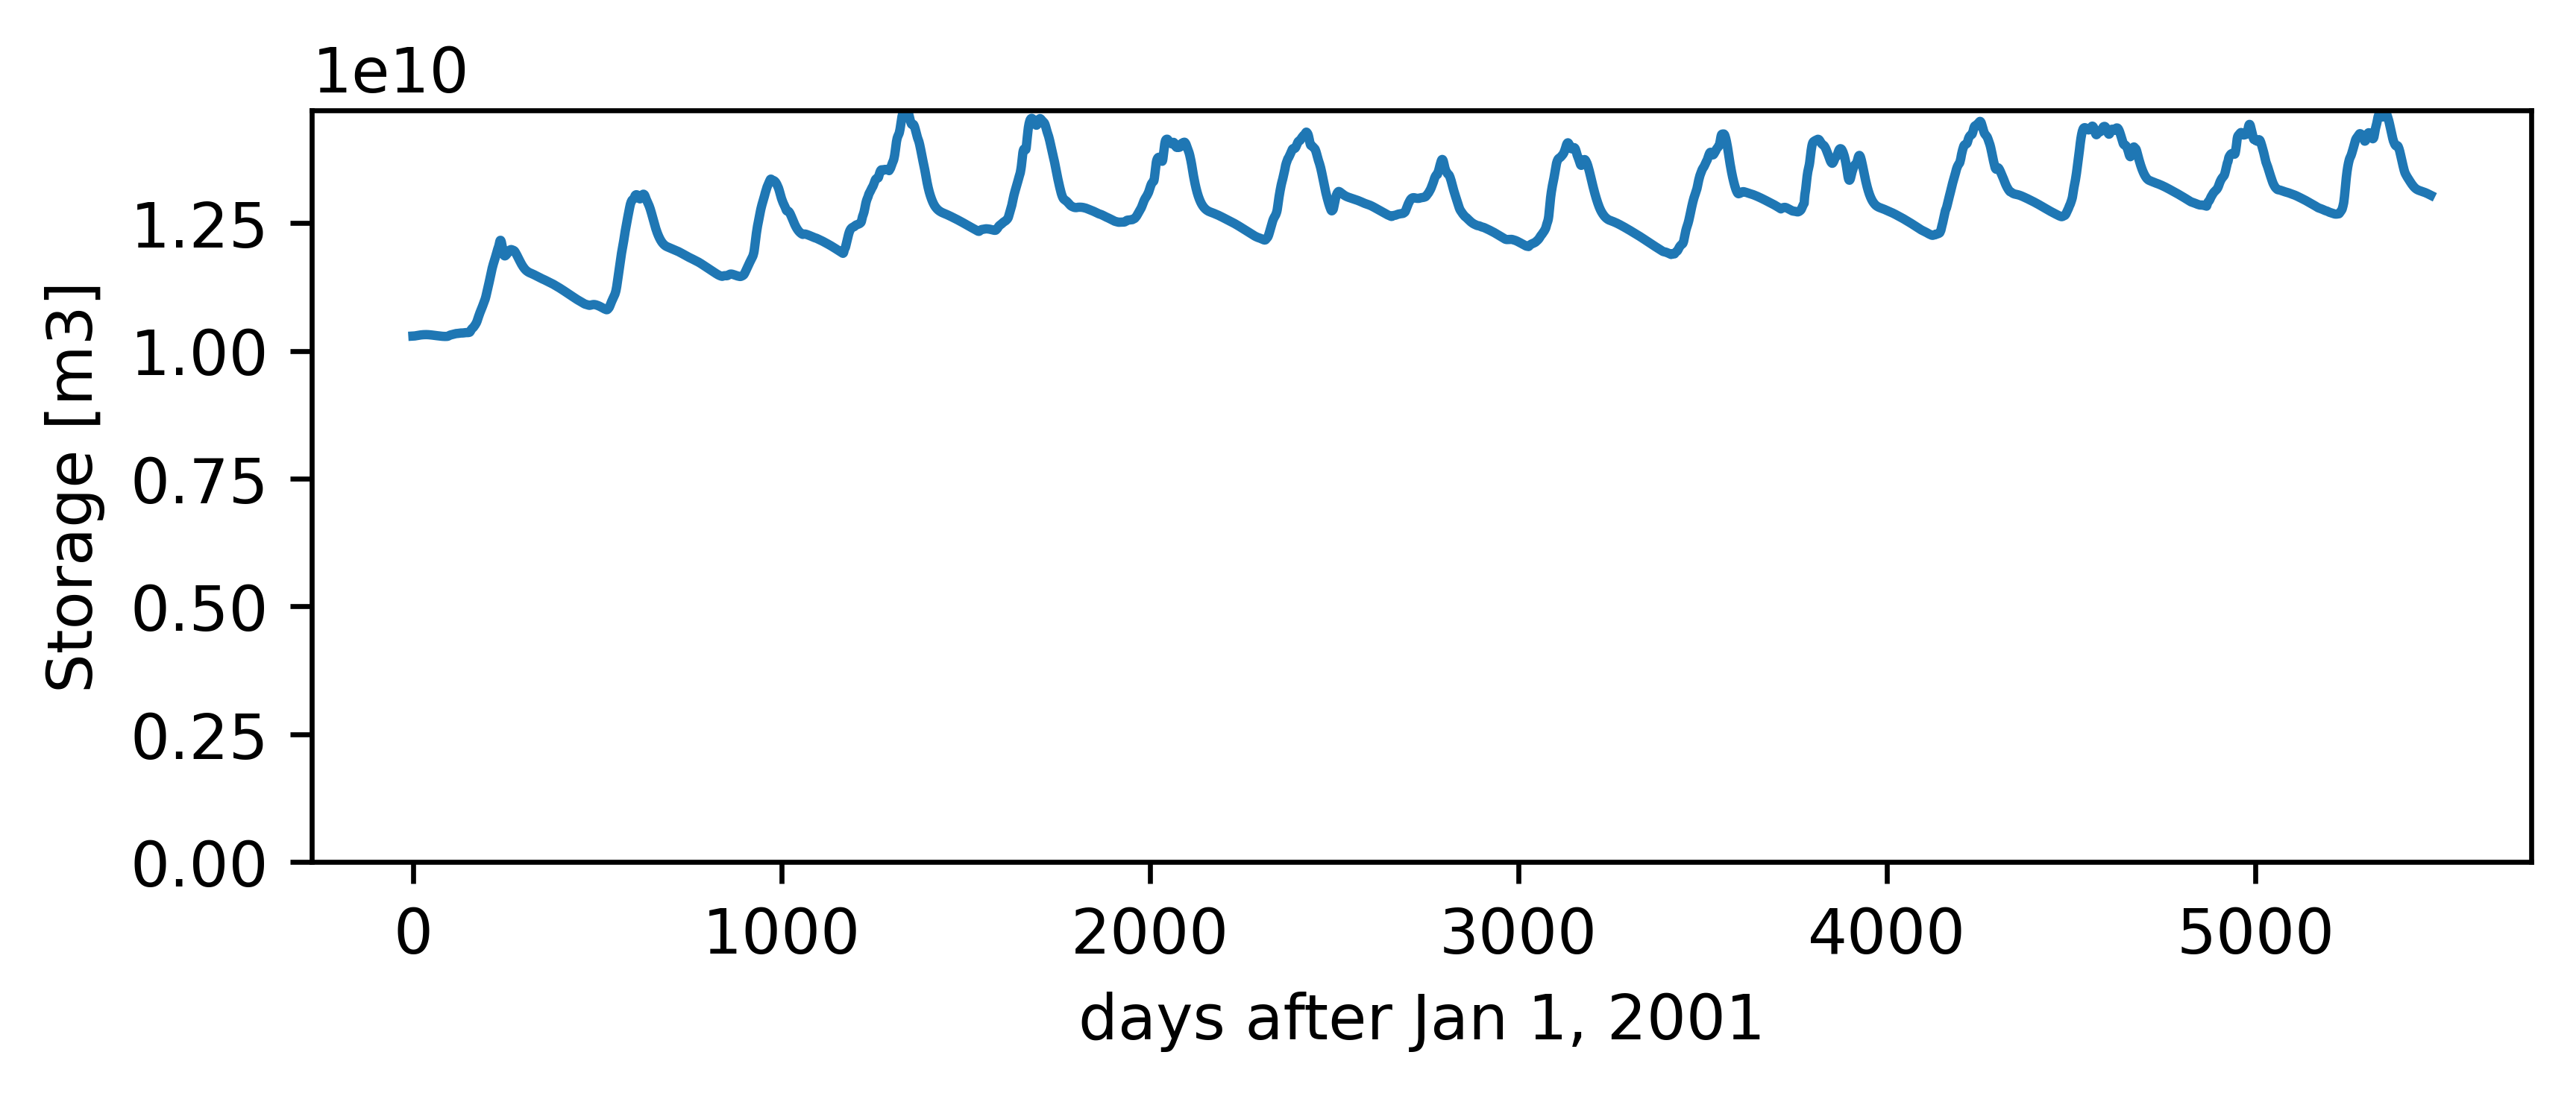

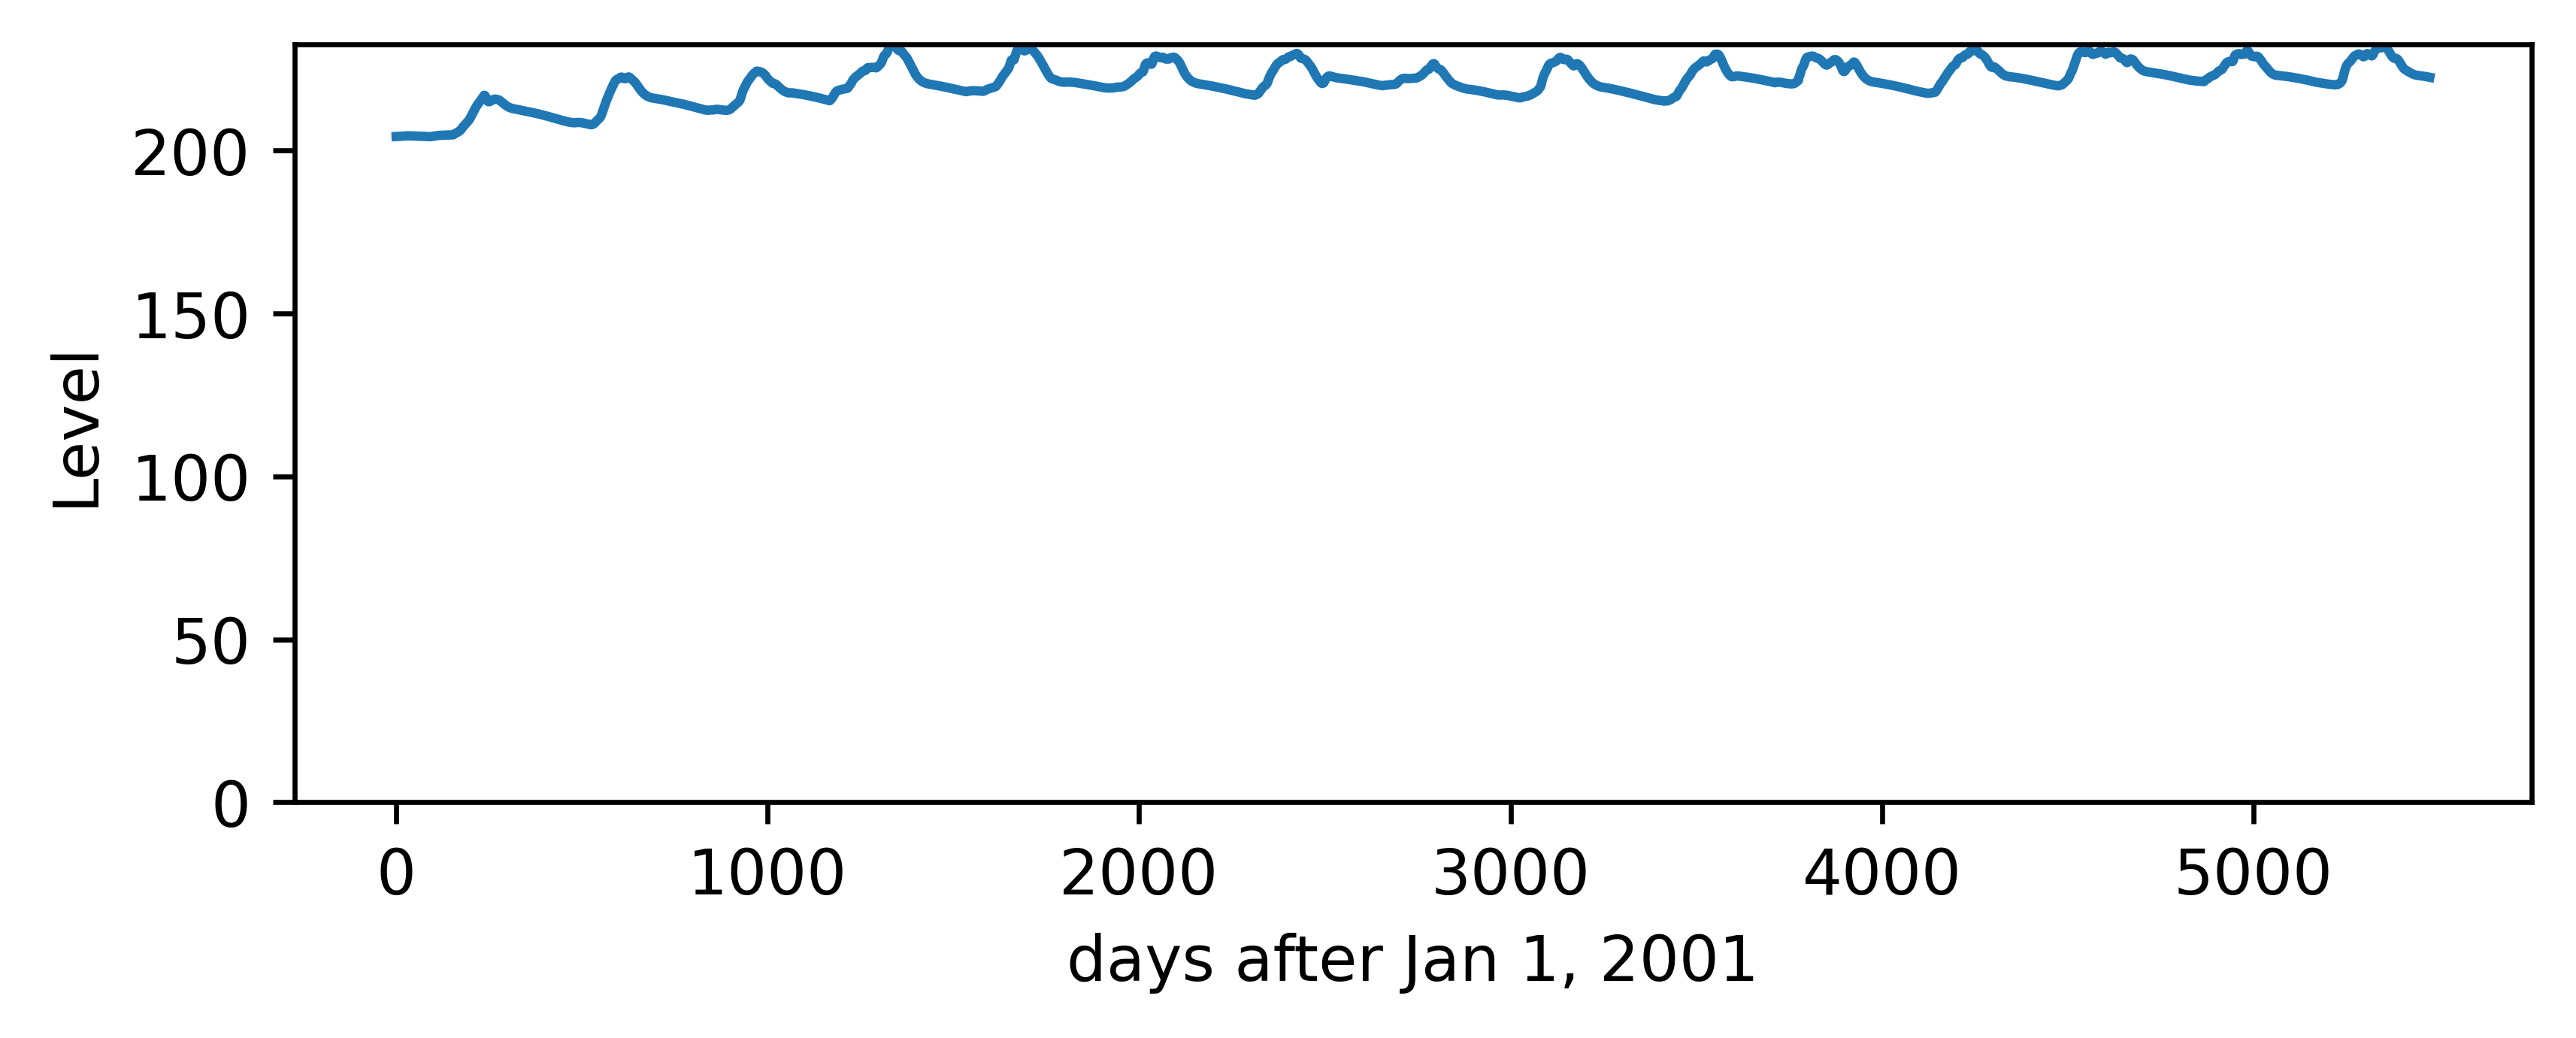

In [ ]:
inflow_ = np.concatenate(([-999], inflow))
release_ = np.concatenate(([-999], release))

for t in range(H):
  evaporation_t = evap[t%365]/1000*s[t]*stor_to_surface/sim_step
  s[t+1] = s[t] + (inflow_[t+1] - release_[t+1] - evaporation_t)*sim_step
  s[t+1] = min(max(0, s[t+1]), S) #check max and min storage physical constraints

# calculate level from the timeseries of storage
l = 0.0521*(s**0.3589)


plt.subplot(2,1,1)
plt.plot(s)
plt.ylabel('Storage [m3]')
plt.xlabel('days after Jan 1, 2001')
plt.ylim([0, S+100])
plt.show()

plt.subplot(2,1,2)
plt.plot(l)
plt.ylabel('Level')
plt.xlabel('days after Jan 1, 2001')
plt.ylim([0, np.max(l)])
plt.show()



We can define a function that performs the mass balance for ease of use:

In [ ]:
def mass_balance_gibeIII(s0, inflow, release, evap):

  inflow_ = np.concatenate(([-999], inflow))
  release_ = np.concatenate(([-999], release))

  s = np.zeros(len(inflow_))
  s[0] = s0

  sim_step = 60*60*24 #seconds per day

  for t in range(H):
    evaporation_t = evap[t%365]/1000*s[t]*stor_to_surface/sim_step
    s[t+1] = s[t] + (inflow_[t+1] - release_[t+1] - evaporation_t)*sim_step
    s[t+1] = min(max(0, s[t+1]), S) #check max and min storage physical constraints

  l = 0.0521*(s**0.3589)

  return s, l

# this function can be called as:
s0 = S*0.7
s,l = mass_balance_gibeIII(s0, inflow, release, evap)


Functions are advantageous when a piece of code needs to be utilized multiple times, for instace in the case we want to test several release strategies:



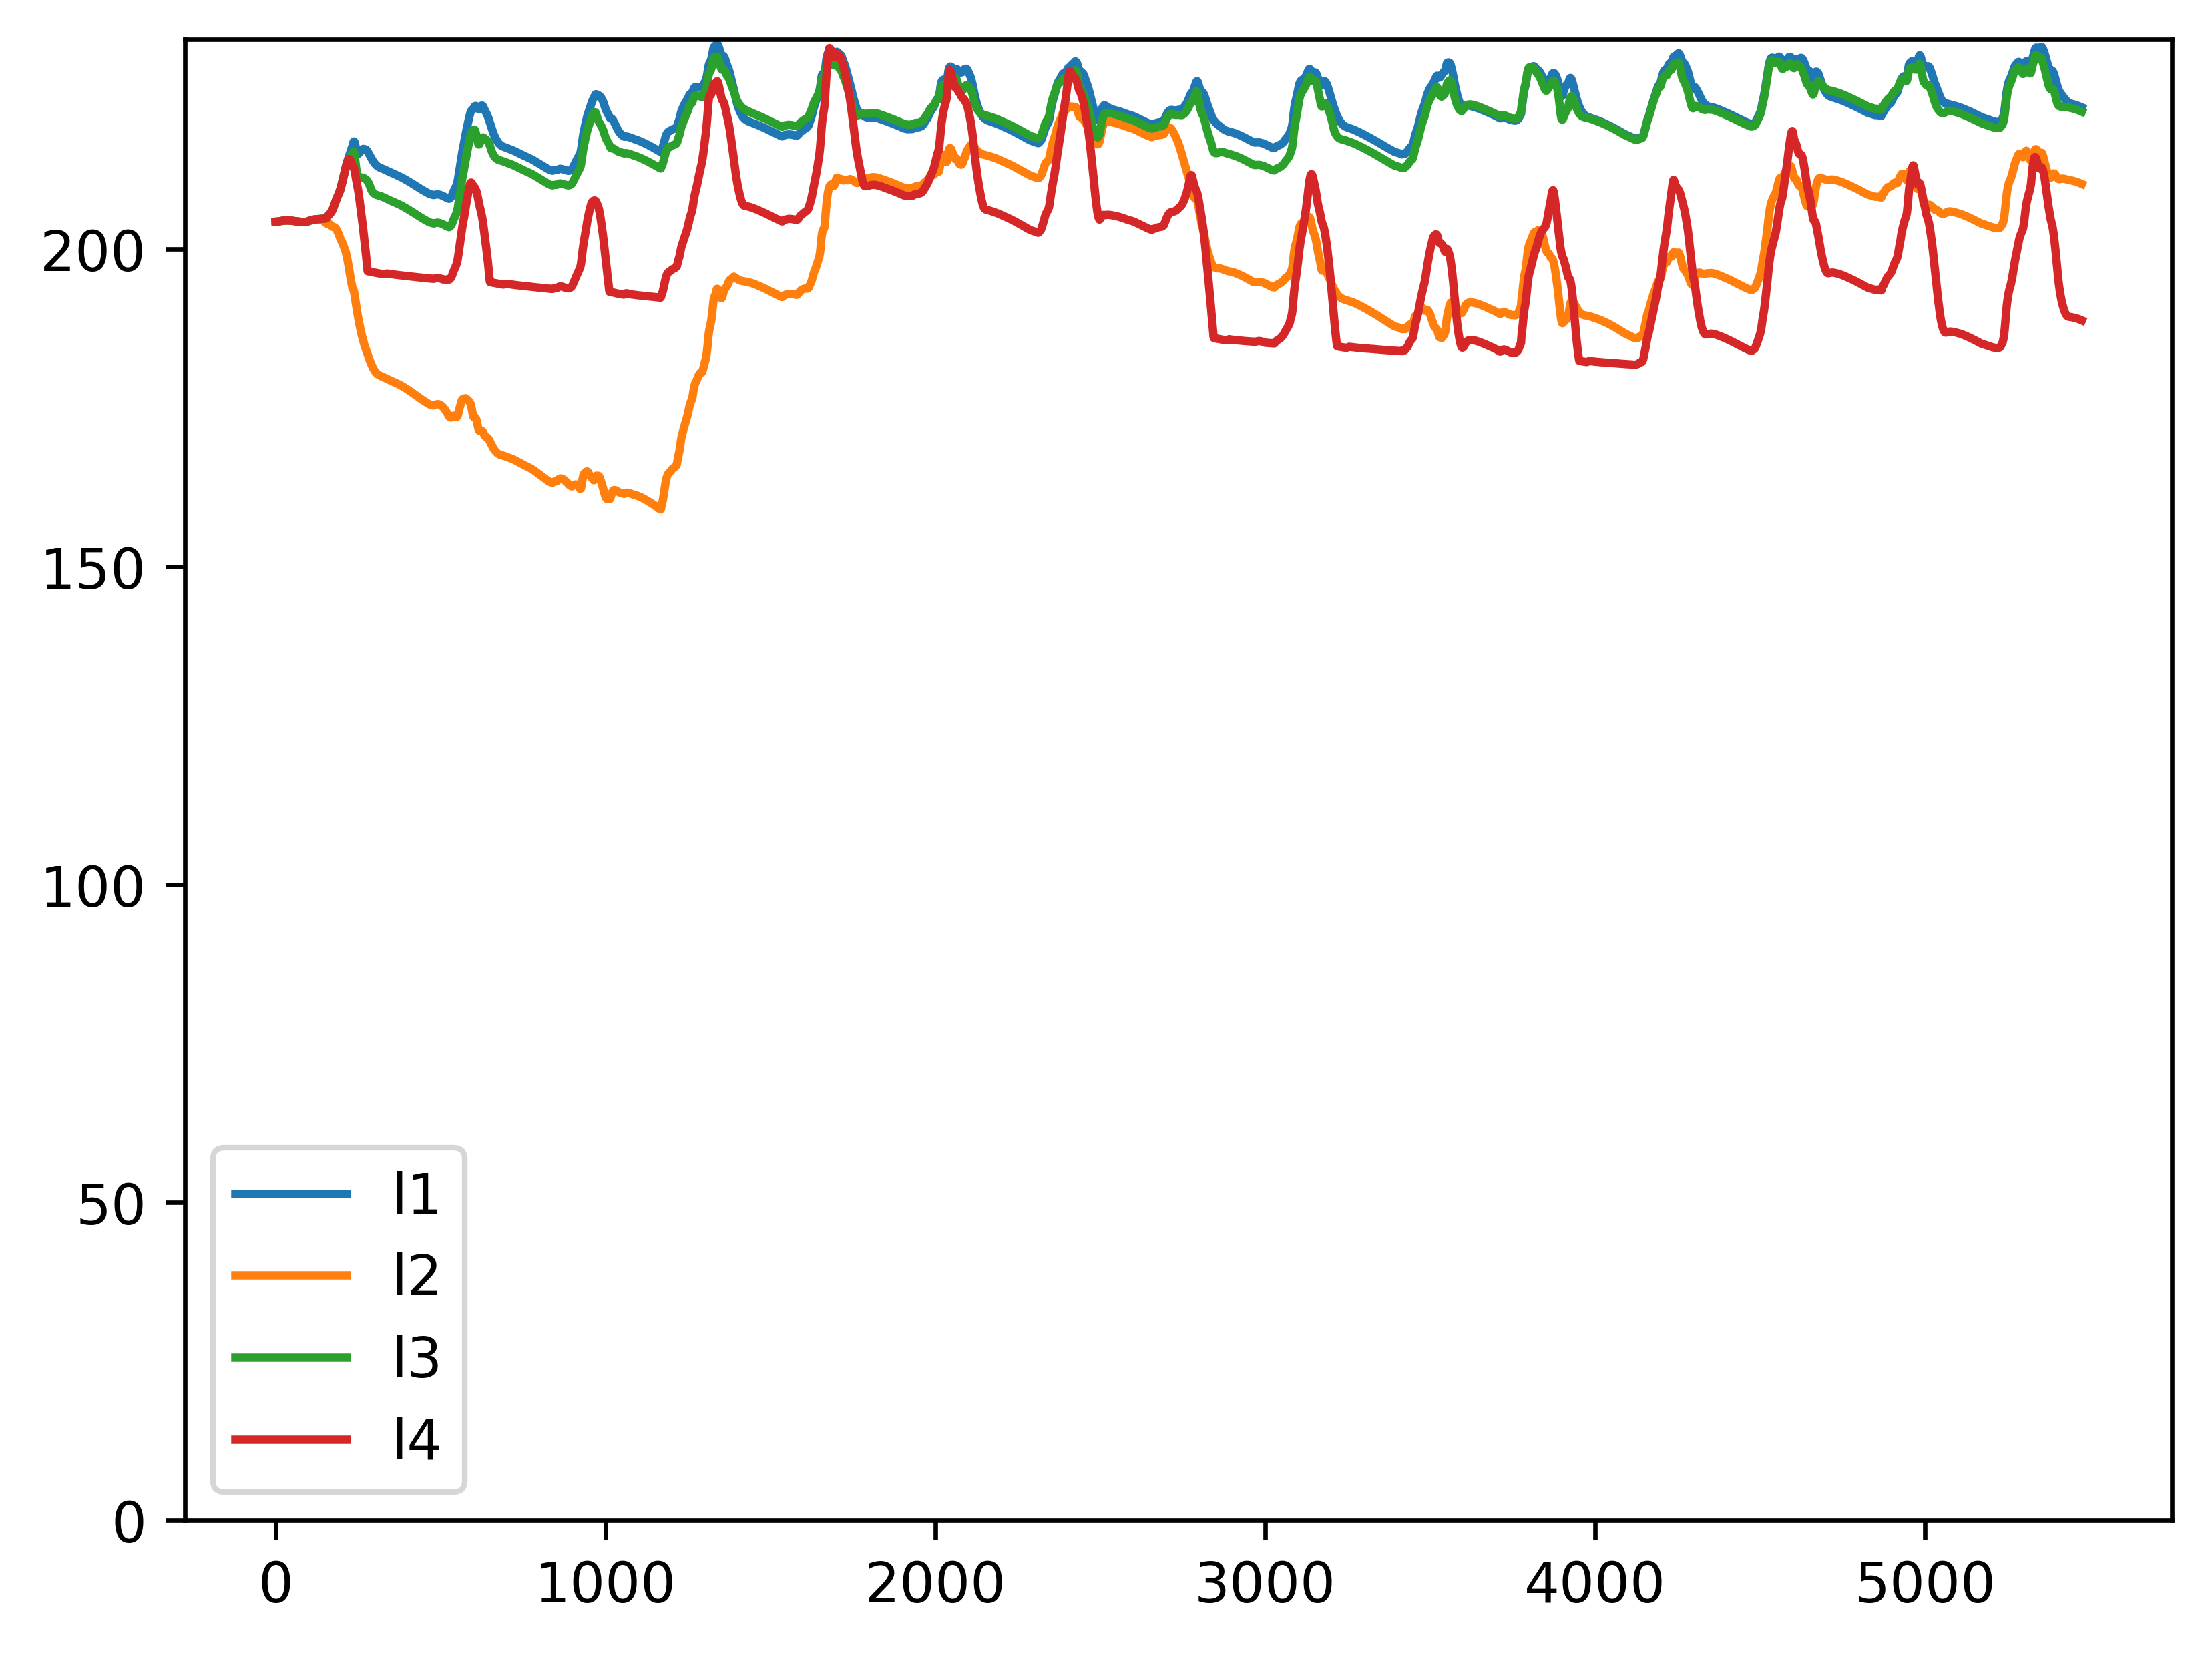

In [ ]:
r1 = release
r2 = np.loadtxt('data/release2.txt', delimiter='\t')
r3 = np.loadtxt('data/release3.txt', delimiter='\t')
r4 = np.loadtxt('data/release4.txt', delimiter='\t')

s1,l1 = mass_balance_gibeIII(s0, inflow, r1, evap)
s2,l2 = mass_balance_gibeIII(s0, inflow, r2, evap)
s3,l3 = mass_balance_gibeIII(s0, inflow, r3, evap)
s4,l4 = mass_balance_gibeIII(s0, inflow, r4, evap)

plt.plot(l1, label = 'l1')
plt.plot(l2, label = 'l2')
plt.plot(l3, label = 'l3')
plt.plot(l4, label = 'l4')
plt.ylim([0, 233])
plt.legend()


In [ ]:
#Save the timeseries of levels

np.savetxt('data/level1.txt', l1, delimiter='\t')
np.savetxt('data/level2.txt', l2, delimiter='\t')
np.savetxt('data/level3.txt', l3, delimiter='\t')
np.savetxt('data/level4.txt', l4, delimiter='\t')

------------